![image info](./thumb0.PNG)

## Table of contents<a name="toc"></a>
1. [Getting started](#intro)    

2. [Importing Libra and other dependencies](#import)      

3. [Kohn-Sham orbital basis](#kohn_sham)    

 3.1.[Read in the Kohn-Sham data](#data_ks)    
 
    3.1.1. [Sanity check](#sanity_ks)  
    
    3.1.2. [Using an active space](#active_sp_ks)  
    
 3.2. [Compute decoherence time in Kohn-Sham basis](#decoherence_ks)    
 
    3.2.1. [Setting initial times](#initial_time_ks) | [Exercise1](#exercise1))  
    
 3.3. [Plot decoherence time in Kohn-Sham basis](#plot_deco_ks) | [Exercise2](#exercise2)    

4. [Slater determinant basis](#slater)    

 4.1.[Read in the Slater determinant data](#data_sd)    
 
    4.1.1. [Sanity check](#sanity_sd)  
    
 4.2. [Compute decoherence time in Slater determinant basis](#decoherence_sd)    
 
 4.3. [Plot decoherence time in Slater determinant basis](#plot_deco_sd)  | [Exercise3](#exercise3)  
    
5. [References](#references)  

### A. Learning objectives

* To be able to initialize a NBRA NAMD calculation after acquiring the necessary data
* Compute decoherence times between the states of the quantum system

### B. Use cases

* [Reading Hamiltonian data files](#data_ks)
* [Computing average_decoherence times](#decoherence_times_ave)
* [Computing average_energy_gaps](#energy_gaps_ave)
* [Plotting dephasing times](#plot_map_nparray)

### C. Functions

- `libra_py`
  - `workflows`
    -  `nbra`
      - `step4`
        - [`get_Hvib2`](#data_ks)
      - `decoherence_times`
        - [`decoherence_times_ave`](#decoherence_times_ave)
        - [`energy_gaps_ave`](#energy_gaps_ave)

  - `data_visualize`
    - [`plot_map_nparray`](#plot_map_nparray)
    - [`plot_MATRIX2nparray`](#plot_MATRIX2nparray)

## 1. Getting started<a name="intro"></a>
[Return to TOC](#toc)

In this tutorial, we will read in the dynamical data from both steps 2 and 3. This means reading the data in the Kohn-Sham orbital basis and the Slater determinant basis, respectively.

For those wishing to start from this step, please unpack the tarball provided in this folder. The names of these tarballs are "ks_step2_data_compressed" and "sd_step3_data_compressed". If not done already, please unpack the tarball. From the command line, this can be done as:

tar -xf res_ks_step2_compressed  
tar -xf res_sd_step3_compressed

This tutorial will show users how to read in this data and to prepare it for Neglect-of-Back-Reaction Approximation NonAdiabatic Molecular Dynamics (NBRA NAMD) calculations. We will be computing the decoherence times for our data.

Before we begin the tutorial, let us unpack the tarballs by running the following cell

In [40]:
!tar -xf res_ks_step2_compressed
!tar -xf res_sd_step3_compressed

## 2. Importing Libra and other dependencies <a name="import"></a>
[Return to TOC](#toc)

In the cell below, we import Libra and other dependencies such as numpy and matplotlib

In [41]:
import os
import sys
import time
import math

# Fisrt, we add the location of the library to test to the PYTHON path
if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
from libra_py import units as units
from libra_py import influence_spectrum as infsp
from libra_py import data_visualize
from libra_py import data_conv
import libra_py.workflows.nbra.step4 as step4
import libra_py.workflows.nbra.decoherence_times as decoherence_times
import libra_py.workflows.nbra.lz as lz
import libra_py.workflows.nbra.qsh as qsh
import numpy as np
import matplotlib.pyplot as plt

colors = {}
colors.update({"1": '#000000'})  # Black 
colors.update({"2": '#000099'})  # Blue  
colors.update({"3": '#006400'})  # Green 
colors.update({"4": '#990000'})  # Red   
colors.update({"5": '#8B008B'})  # Purple
colors.update({"6": '#FF8C00'})  # Orange
colors.update({"9": '#4d4d4d'})  # Gray  
color_index = ["1","2","3","4","5","6","9"]


## 3. Kohn-Sham orbital basis<a name="kohn_sham"></a>
[Return to TOC](#toc)

### 3.1.  Read in the Kohn-Sham data<a name="data_ks"></a>
[Return to TOC](#toc)

Recall that the electronic wavefunctions in the Kohn-Sham orbital basis are computed along the precomputed nuclear trajectories are stored in the folder "res_ks_step2"

In [42]:
print ("\nGathering data from MD ")
print ("Considering system", "Libra Tutorial: Single Rutile TiO2 Unit Cell - Kohn-Sham basis")

absolute_path = os.getcwd()
params = {}
params["data_set_paths"] = []
params["data_set_paths"].append(absolute_path+"/res_ks_step2/")

params["Hvib_re_prefix"] = "hvib_dia_"; params["Hvib_re_suffix"] = "_re"
params["Hvib_im_prefix"] = "hvib_dia_"; params["Hvib_im_suffix"] = "_im"
params["nfiles"]         = 100
params["init_times"]     = [0]

params["nstates"]        = 22 # total number of electronic states
params["active_space"]   = list( range(params["nstates"]) ) # indexing is from 0!

# Include HOMO and up to the last electronic state
hvib = step4.get_Hvib2(params)
print ("Length of hvib is: ", len(hvib[0]))


Gathering data from MD 
Considering system Libra Tutorial: Single Rutile TiO2 Unit Cell - Kohn-Sham basis
Length of hvib is:  100


#### 3.1.1 Sanity check <a name="sanity_ks"></a>
[Return to TOC](#toc)

We need to print an element of hvib to see if we have anything meaningful. A lot of times, when I run this I somehow don't read the data correctly. When the data is read incorrectly, the hvib lists will contain matrices full of 0's. So, let's print some matrix elements of hvib[0] to see if we get non-zero values. If these values happen to turn up all zero, you should reconsider the paths to your hvib files and their names. There is also the possibility that the values you see here are non-zero, yet incorrect. This may happen if your pathing is correcting but you do not have the correct number for the parameter, nstates. Please double check these printed values with the values in the actual hvib files to see if they match.

In [43]:
#Print the matrix elements: 0,0 1,1  0,1 0,2 . 
# The matrix elemnts are extracted with the .get() function

print ( "\n Test, for energies, Ha ")
print ( "hvib[0][0].get(0,0) = ",  hvib[0][0].get(1,1) )
print ( "hvib[0][0].get(1,1) = ",  hvib[0][0].get(0,0) )

print ( "\n Test, for nacs, Ha ")
print ( "hvib[0][0].get(0,1) = ",  hvib[0][0].get(0,1) )
print ( "hvib[0][0].get(0,2) = ",  hvib[0][0].get(0,2) )



 Test, for energies, Ha 
hvib[0][0].get(0,0) =  (0.32972698+0j)
hvib[0][0].get(1,1) =  (0.28508843+0j)

 Test, for nacs, Ha 
hvib[0][0].get(0,1) =  5.7298174e-06j
hvib[0][0].get(0,2) =  9.0869418e-06j


#### 3.1.2 What if I don't want to include all 22 Kohn-Sham orbitals in my active space?? <a name="active_sp_ks"></a>
[Return to TOC](#toc)

This is a common question. Luckily, Libra allows us to select a particular active space to consider in the dynamics. 

In the above example, we used all 11 alpha and 11 beta orbitals in the active space. But what if we wanted to only consider the alpha and beta orbitals for the conduction band maximum and valance band minimum?

To do this, we first must remember what the index of the CBM and VBM are from 0. We start from 0 here because the computer indexes the first row and column matrix elements from 0. In this case, the index of the CBM in the alpha spin channel was index 5 and the CBM in the beta spin channel was 16. Please revisit the previous tutorials for building a Slater determinant basis for a refresher on this. The following schematic may also assist you.

![image info](./thumb1.PNG)

### 3.2. Compute decoherence time in Kohn-Sham basis<a name="decoherence_ks"></a>
[Return to TOC](#toc)

In Libra, the decoherence time is computed as the dephasing times as according to linear response formalism.$^1$ What we compute is a matrix, $\tau$, which contains the decoherence times between all considered quantum (electronic) states in our system.

$$ \large{\tau} = \sqrt{ \frac{\frac{12}{5} \hbar^2 }{dE} } $$

Where the matix elements of $dE$ are the expectation value of the energy gap fluctation between some states i and j.

$$ \large{ dE_{ij} = < \delta E_{ij}^2(t)  > } $$

and $ \delta E_{ij}(t) $ is computed as 

$$ \large{  \delta E_{ij}(t) = E_{ij}(t) - < E_{ij} > } $$

Before we compute the decoherence time for the quantum states in our system, we must first decide how much of the precomputed nuclear dynamics trajectory we want to keep. This step is useful because typically molecular dynamics data features a thermalization step in which the molecular dynamics data is unreliable for dynamics purposes.

When reading in our Hamiltonian data, we read 100 files, because we had taken 100 molecular dynamics steps. At this time, we can choose to take either the entirety of the 100 files or use only a subset of these for dynamics. this can be done with the following parameter keys:

`params["init_times"]` -  a list of integers denoting the initial times for the NBRA NAMD. The simulation will run from `params["init_times"]`[i] to `params["init_times"]`[i] + nsteps, for each `params["init_times"]`

`params["nsteps"]` - an integer denoting the number of steps to take in the NBRA NAMD. This number cannot be bigger than the number set for parameter key, `params["nfiles"]`. Please note, that for each value of `params["init_times"]`, we will take nsteps steps.


In total, here is the summary:

1. We read our data along the precomputed nuclear dynamics trajectory. This will be of size `params["nfiles"]`. In this case, we have 100 files

2. We define the starting points of what will be the NBRA NAMD with the parameter, `params["init_times"]`.

3. At each initial time listed in `params["init_times"]`, we compute `params["nsteps"]` worth of NBRA NAMD. 

#### 3.2.1 Setting initial times <a name="initial_time_ks"></a>
[Return to TOC](#toc)

Possibility 1

In [44]:
params["init_times"] = [49]
params["nsteps"] = 50

Possibility 2, etc

In [45]:
#params["init_times"] = [0]
#params["nsteps"] = 99

For now, we will use Possibility 1. Let's go ahead and use this part of the trajectory. Now need to comment out possibility 1, as it has already been over written by possibility 2

In [46]:
# Compute energy gaps and decoherence times over part of the trajectory we want. Using the init_times parameter
tau, rates = decoherence_times.decoherence_times_ave(hvib, [params["init_times"][0]], params["nsteps"], 0)
dE         = decoherence_times.energy_gaps_ave(      hvib, [params["init_times"][0]], params["nsteps"])
avg_deco   = tau * units.au2fs
print ("Finished gather data for MD time", params["nsteps"], "steps.")
print ("Dephasing time between Kohn-Sham orbitals 0 and 1 is:", tau.get(0,1) * units.au2fs, "fs")

Finished gather data for MD time 50 steps.
Dephasing time between Kohn-Sham orbitals 0 and 1 is: 10.551461648521352 fs


### Exercise 1<a name="exercise1"></a>
[Return to TOC](#toc)

It has been established that we have 100 data files and each data file corresponds to a 1.0 fs integration time step. What should the parameters `params["init_times"]` and `params["nsteps"]` be set to if one wanted to compute the dephasing times for the section of the trajectory spanning t = 25 fs to t = 75 fs?. Recall the index 0 corresponds to t = 0 fs.

params["init_times"] = [?]

params["nsteps"] = [?]


### 3.3. Plotting the decoherence times for Kohn-Sham basis<a name="plot_deco_ks"></a>
[Return to TOC](#toc)
<a name="plot_map_nparray"></a>
<a name="plot_MATRIX2nparray"></a>

We are now going to plot the decoherence times. Below is a code snippet plot the decoherence times in matplotlib. Please notice how elements of Libra MATRIX data is extract using the feature ".get(i,j)", where i and j are elements of the MATRIX we wish to extract. The trajectory averaged dephasing times between the Kohn-Sham orbitals is visualized using Libra's data_visualize module. Here, we use the function plot_map_nparray(..) 

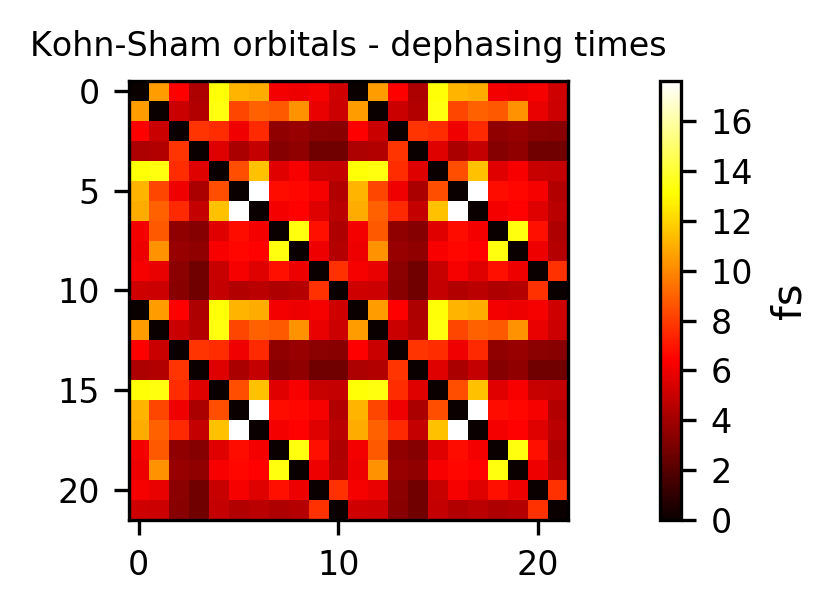

In [47]:
tau_kohn_sham = data_conv.MATRIX2nparray( tau ) * units.au2fs
for i in range( len(tau_kohn_sham) ):
    tau_kohn_sham[i][i] = 0.0
title_kohn_sham = "Kohn-Sham orbitals - dephasing times"
data = [tau_kohn_sham]
subplot_titles = [title_kohn_sham ]
data_visualize.plot_map_nparray( plt, data, fig_width=6.42, fig_height=2.14, titles=subplot_titles, \
                                 title_size=8, num_subplots=1, colormap='hot', \
                                 interpolation_scheme='nearest', colorbar_label='fs' )

Since the spin-polarization in our system is negligible, there is no observable difference between the decoherence times for the Kohn-sham orbitals in the alpha and beta spin channels. The small dephasing times are likely due to the very rough estimation to the molecular dynamics in our tutorials example.

### Exercise 2<a name="exercise2"></a>
[Return to TOC](#toc)

We manually set the dephasing times between quantum states of the same index (diagonal elements of tau) to be zero. We did this because the computed dephasing times for these states is infinity, and having extremely large values would look bad when plotting. Anyways, why do the diagonal elements of tau compute to be infinity?

HINT: Recall the mathematical formulas above 

## 4. Slater determinant basis<a name="slater"></a>
[Return to TOC](#toc)

Up until now, we have been using the Kohn-Sham basis we generated in the step2 calculations with Quantum Espresso. Recall that we also had taken these Kohn-Sham orbitals and formed a slater determinant basis, in which the Slater determinant energies were approximated as the sums of the 1-electron energies of the underlying Kohn-sham orbitals. Also please recall that we named the files storing the Hamiltonian in the Slater determinant basis, Hvib_sorted_#_(re/im). Therefore, we need to change the path, `params["data_set_paths"]`, to the correct data. 

Furthermore, we had used Libra to auto-generate our Slater determinant basis. Specifically, Libra generated 17 Slater determinants. Therefore, we need to change the number of states, `params["nstates"]`, we extract from the Hamiltonian files. 

### 4.1.  Read in the Slater determinant data<a name="data_sd"></a>

Recall that the electronic wavefunctions in the Slater determinant orbital basis are computed along the precomputed nuclear trajectories are stored in the folder "res_sd_step3"

[Return to TOC](#toc)

In [48]:
print ("\nGathering data from MD ")
print ("Considering system", "Libra Tutorial: Single Rutile TiO2 Unit Cell - Slater determinant basis")

absolute_path = os.getcwd()
params = {}
params["data_set_paths"] = []
params["data_set_paths"].append(absolute_path+"/res_sd_step3/")

params["Hvib_re_prefix"] = "Hvib_sorted_"; params["Hvib_re_suffix"] = "_re"
params["Hvib_im_prefix"] = "Hvib_sorted_"; params["Hvib_im_suffix"] = "_im"
params["nfiles"]         = 100
params["init_times"]     = [0]

params["nstates"]        = 17 # total number of electronic states
params["active_space"]   = list( range(params["nstates"]) ) # indexing is from 0!

# Include HOMO and up to the last electronic state
hvib_sd = step4.get_Hvib2(params)
print ("Length of hvib is: ", len(hvib[0]))


Gathering data from MD 
Considering system Libra Tutorial: Single Rutile TiO2 Unit Cell - Slater determinant basis
Length of hvib is:  100


#### 4.1.1 Sanity check<a name="sanity_sd"></a>
[Return to TOC](#toc)

Let's now do our sanity check for the Slater determinant data

In [49]:
#Print the matrix elements: 0,0 1,1  0,1 0,2 . 
# The matrix elemnts are extracted with the .get() feature

print ( "\n Test, for energies, Ha ")
print ( "hvib_sd[0][0].get(0,0) = ",  hvib_sd[0][0].get(1,1) )
print ( "hvib_sd[0][0].get(1,1) = ",  hvib_sd[0][0].get(0,0) )

print ( "\n Test, for nacs, Ha ")
print ( "hvib_sd[0][0].get(0,1) = ",  hvib_sd[0][0].get(0,1) )
print ( "hvib_sd[0][0].get(0,2) = ",  hvib_sd[0][0].get(0,2) )



 Test, for energies, Ha 
hvib_sd[0][0].get(0,0) =  (2.7952217+0j)
hvib_sd[0][0].get(1,1) =  (2.7573188+0j)

 Test, for nacs, Ha 
hvib_sd[0][0].get(0,1) =  0.00012208088j
hvib_sd[0][0].get(0,2) =  -9.8259835e-05j


We can also see them in the units of eV. Be aware that for the energies one should be concerned the energy gaps, and not nesscarily the energies themsevles. 

In [50]:
#Print the matrix elements: 0,0 1,1  0,1 0,2 . 
# The matrix elemnts are extracted with the .get() feature

print ( "\n Test, for energies, eV ")
print ( "hvib_sd[0][0].get(0,0) = ",  hvib_sd[0][0].get(1,1) * units.au2ev )
print ( "hvib_sd[0][0].get(1,1) = ",  hvib_sd[0][0].get(0,0) * units.au2ev )

print ( "\n Test, for nacs, eV ")
print ( "hvib_sd[0][0].get(0,1) = ",  hvib_sd[0][0].get(0,1) * units.au2ev )
print ( "hvib_sd[0][0].get(0,2) = ",  hvib_sd[0][0].get(0,2) * units.au2ev )


 Test, for energies, eV 
hvib_sd[0][0].get(0,0) =  (76.06077767869999+0j)
hvib_sd[0][0].get(1,1) =  (75.0294018668+0j)

 Test, for nacs, eV 
hvib_sd[0][0].get(0,1) =  0.00332194282568j
hvib_sd[0][0].get(0,2) =  -0.002673748370185j


### 4.2 Compute decoherence time in Slater determinant basis<a name="decoherence_sd"></a>
[Return to TOC](#toc)

Using the full molecular dynamics, let's compute the decoherence time as done above, but using the Slater determinant basis now.

<a name="decoherence_times_ave"></a>
<a name="energy_gaps_ave"></a>

In [51]:
params["init_times"] = [49]
params["nsteps"] = 50
# Compute energy gaps and decoherence times over part of the trajectory we want
tau_sd, rates_sd = decoherence_times.decoherence_times_ave(hvib_sd, [params["init_times"][0]], params["nsteps"], 0)
dE_sd = decoherence_times.energy_gaps_ave(hvib_sd, [params["init_times"][0]], params["nsteps"])
avg_deco_sd = tau_sd * units.au2fs
print ("Finished gather data for MD time", params["nsteps"], "steps.")
print (tau_sd.get(0,1) * units.au2fs)

Finished gather data for MD time 50 steps.
8.480358651664996


### 4.3. Plotting the decoherence times for Slater determinant basis<a name="plot_deco_sd"></a>
[Return to TOC](#toc)

We will use the same plotting script as above but adjusted for the new variable names.

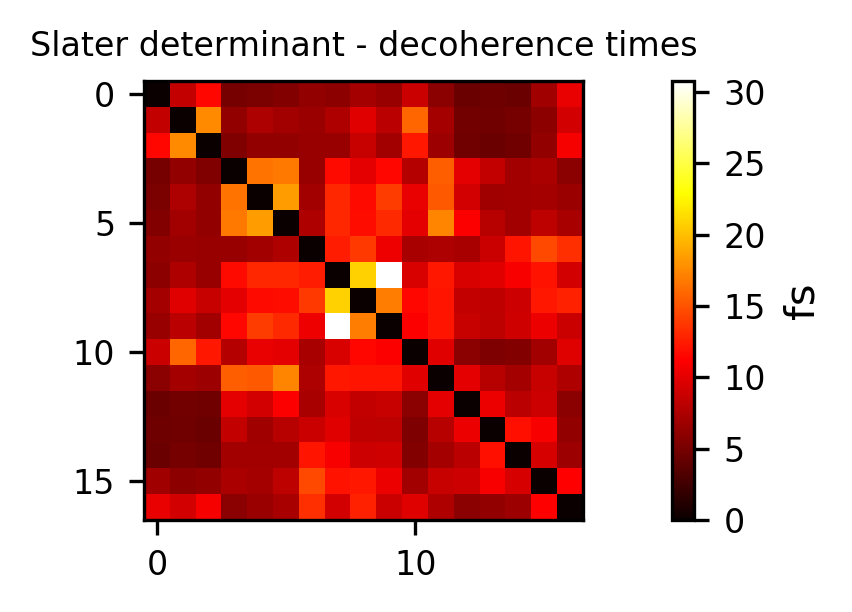

In [52]:
tau_slater_determinant = data_conv.MATRIX2nparray( tau_sd ) * units.au2fs
for i in range( len(tau_slater_determinant) ):
    tau_slater_determinant[i][i] = 0.0
title_slater = "Slater determinant - decoherence times"
data = [tau_slater_determinant]
subplot_titles = [title_slater]
data_visualize.plot_map_nparray( plt, data, \
                                fig_width=6.24, fig_height=2.14, titles=subplot_titles, \
                                title_size=8, num_subplots=1, colormap='hot', \
                                interpolation_scheme='nearest', colorbar_label='fs' )


### Exercise 3<a name="exercise3"></a>
[Return to TOC](#toc)

In the Kohn-Sham orbital basis, index zero happened to correspond to CBM-4. However, in the Slater determinant basis, index zero is referred to as the ground state. Why is this? In other words, why is index 0 in the Kohn-Sham basis not referred to as the ground state, yet index 0 in the Slater determinant basis is?


## 5. References<a name="references"></a>
[Return to TOC](#toc)

1. Akimov, A. V.; Prezhdo, O. V. Persistent Electronic Coherence Despite Rapid Loss of Electron–Nuclear Correlation. J. Phys. Chem. Lett. 2013, 4 (22), 3857–3864